<a href="https://colab.research.google.com/github/Vyshnavi153/Applied-NLP/blob/main/Vyshnavi_Daka_HW4B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Why we do not need collate function while using sparse embeddings?**
While using embedding bad layer, collate function is used to perform custom preprocessing like padding text sequences to uniform length in order to handle variable-sized inputs, such as different lengths of text.
But collate function is not needed while creating sparse embeddings using tfidf vectorizer because bag-of-words approach would create tensors of equal size i.e., the size of the vocabulary regardless of the actual length of the text sequence.

# <Font color = 'indianred'>**1. Set Environment** </font>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from pathlib import Path
import sys

# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# General-purpose Python libraries for random number generation and numerical operations
import random

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from sklearn.metrics import confusion_matrix

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Printing: Import the pprint function from the pprint module for formatted output of text
from pprint import pprint

from torch.nn.utils import clip_grad_value_

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix


In [2]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq
  # Install the latest version of torchtext library quietly without showing output

  !pip install torchtext -qq
  # Install the torchinfo library quietly
  !pip install torchinfo -qq

  basepath = '/content/drive/MyDrive/data'
  sys.path.append('/content/drive/MyDrive/data/custom-functions')
else:
  basepath = 'D:/UTDallas/Courses/Spring 24/Applied NLP/Data Folder'
  sys.path.append(
        'D:/UTDallas/Courses/Spring 24/Applied NLP/Data Folder/custom-functions')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
base_folder = Path(basepath)
data_folder = base_folder / 'datasets/stack_exchange'
model_folder = base_folder / 'models/nlp_spring_2024/stack_exchange'

In [4]:
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

## <Font color = 'indianred'>**2. Load Data**

In [5]:
stack_exchange_df = joblib.load(data_folder/ 'df_multilabel_hw_cleaned.joblib')

In [6]:
stack_exchange_df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [7]:
stack_exchange_df.dtypes

cleaned_text    object
Tags            object
Tag_Number      object
dtype: object

In [8]:
from ast import literal_eval
stack_exchange_df['Tag_Number'] = stack_exchange_df['Tag_Number'].apply(lambda x: literal_eval(x))

In [9]:
stack_exchange_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47427 entries, 0 to 47426
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  47427 non-null  object
 1   Tags          47427 non-null  object
 2   Tag_Number    47427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [10]:
stack_exchange_df.isna().sum()

cleaned_text    0
Tags            0
Tag_Number      0
dtype: int64

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(stack_exchange_df['Tag_Number']) # One-hot encoding of dependent variable

In [12]:
print(labels)
print(mlb.classes_)

[[1 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
[0 1 2 3 4 5 6 7 8 9]


In [13]:
y = labels
y = torch.tensor(y, dtype = torch.float32)
print(y)

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [14]:
X = stack_exchange_df['cleaned_text'].values

In [15]:
X

array(['asp query stre dropdown webpage follow control relevance    dropdownlist value hyperlink redirect page call   page cancel button redirect user menu page like user click hyperlink edit page index dropdownlist preserve query string page follow aspx code sure proceed < asp hyperlink      id="lnkedit      navigateurl=\'<% + eval("userid + sure > < /asp hyperlink >   < asp dropdownlist      id="mydropdown      < asp listitems/ > < /asp dropdownlist >   edit clarify m navigateurl query string eval determine user id',
       'run javascript code server java code want run javascript code server want manipulate result return javascript inside java code',
       'linq sql throw exception row find change hi linq sql get error row find change update table help linq query show error unable figure problem work get permanent solution fix problem twtmob_campainincomedetails_tb incomedetails = datacontext.twtmob_campainincomedetails_tbs single(twtincome = > = = tempincome                  decim

In [16]:
X.shape, y.shape

((47427,), torch.Size([47427, 10]))

# <Font color = 'indianred'>**2. Data Splitting**

In [17]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and temporary sets (60% - 40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Splitting the temporary set into validation and test sets (50% - 50% of 40%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (28456,) torch.Size([28456, 10])
Validation set shape: (9485,) torch.Size([9485, 10])
Test set shape: (9486,) torch.Size([9486, 10])


In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
X_train_tfidf_vector = X_train_tfidf.toarray()
X_valid_tfidf_vector = X_valid_tfidf.toarray()
X_test_tfidf_vector = X_test_tfidf.toarray()
print((X_train_tfidf_vector > 0).sum())
print((X_valid_tfidf_vector > 0).sum())
print((X_test_tfidf_vector > 0).sum())

1060705
351458
347335


In [20]:
num_inputs = len(tfidf_vectorizer.get_feature_names_out())
print(num_inputs)

5000


# <Font color = 'indianred'>**3. Custom Dataset Class**

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):

        return len(self.X)

    def __getitem__(self, idx):
              # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (texts, labels)

        return sample

In [22]:
trainset = CustomDataset(X_train_tfidf_vector, y_train)
validset = CustomDataset(X_valid_tfidf_vector, y_val)
testset = CustomDataset(X_test_tfidf_vector, y_test)

<ipython-input-21-e06ec8113311>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [23]:
trainset, validset, testset

(<__main__.CustomDataset at 0x7a9776da9450>,
 <__main__.CustomDataset at 0x7a9776db6620>)

In [24]:
trainset[2]

(array([0., 0., 0., ..., 0., 0., 0.]),
 tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]))

# <Font color = 'indianred'>**4. Custom Model Class** </font>

In [25]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, output_dim):
        super().__init__()

        # Linear->ReLU->Dropout->BatchNorm->Linear->ReLU->Dropout->BatchNorm->Linear

        # First Hidden Linear layer
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=0.5)
        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)


        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=0.5)
        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)


        # Final Linear layer
        self.linear3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):

        # First linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear1(x.float())
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        # Second linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # Final linear layer
        x = self.linear3(x)

        return x

# <Font color = 'indianred'>**5. Functions to train & evaluate Models**


In [26]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 17.5 MB/s eta 0:00:00


In [27]:
from torchmetrics import HammingDistance

## <Font color = 'indianred'>*5.1. step() Function*

In [28]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model = model.to(device)
    inputs = inputs.to(device)


    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    with torch.no_grad():
      correct = (outputs.data>=0.5).float()
      # Update Hamming Distance metric
      train_hamming_distance.update(correct, targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        clip_grad_value_(model.parameters(), clip_value=10.0)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, train_hamming_distance
    else:
        return None, outputs, train_hamming_distance

## <Font color = 'indianred'>*5.2. train_epoch() function*

In [29]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, train_hamming = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()


    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    epoch_hamming_distance = train_hamming.compute()
    #print(f'Epoch: {epoch + 1} / {epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Hamming Distance: {epoch_hamming_distance:.4f}')

    train_hamming.reset()

    return train_loss, epoch_hamming_distance


## <Font color = 'indianred'>*5.3. val_epoch() function*

In [30]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, val_hamming = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()


    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    epoch_hamming_distance = val_hamming.compute()
    #print(f'Epoch: {epoch + 1} / {epochs}')
    print(f'Train Loss: {val_loss:.4f} | Train Hamming Distance: {epoch_hamming_distance:.4f}')

    val_hamming.reset()
    return val_loss, epoch_hamming_distance


## <Font color = 'indianred'>*5.4. train() function*

In [31]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_ham_history = []
    valid_ham_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_ham = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_ham = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_ham_history.append(train_ham.to('cpu').numpy())
        valid_loss_history.append(valid_loss)
        valid_ham_history.append(valid_ham.to('cpu').numpy())

        # Output epoch-level summary
        print(f'Epoch: {epoch + 1} / {epochs}')
        print(f'Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_ham:.4f}')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Hamming Distance: {valid_ham:.4f}')
        print()

    return train_loss_history, train_ham_history, valid_loss_history, valid_ham_history

# <Font color = 'indianred'>**6. Train Model**

## <Font color = 'indianred'>*6.1. Hyperparameters*

In [32]:
# model Parameters
input_dim=num_inputs
Output_Dim=10
Hidden_dim1=200
Hidden_dim2=100
Num_Outputs=10

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.000
CLIP_TYPE = 'value'
CLIP_VALUE = 10
PATIENCE=5
OPTIMIZER = 'AdamW'

## <Font color = 'indianred'>*6.2. Training Configuration*

In [33]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
model_stack_1 = SimpleMLP(input_dim=num_inputs,
                       hidden_dim1=Hidden_dim1,
                       hidden_dim2=Hidden_dim2,
                       drop_prob1=0.5,
                       drop_prob2=0.5,
                       output_dim=Num_Outputs)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_stack_1.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## <Font color = 'indianred'>*6.3 Sanity Check*

In [34]:
#Sanity Check
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = inputs.to(device)
    targets = targets.to(device)
    model_stack_1 = model_stack_1.to(device)
    model_stack_1.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_stack_1(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')


Actual loss: 0.6772316098213196
Expected Theoretical loss: 0.6931471805599453


## <Font color = 'indianred'>*6.4 Training*

In [35]:
# Call the train function to train the model
train_losses, train_ham, valid_losses, valid_ham = train(
    train_loader, valid_loader, model_stack_1, optimizer, loss_function, EPOCHS, device
)

Train Loss: 0.3452 | Train Hamming Distance: 0.0775
Train Loss: 0.1428 | Train Hamming Distance: 0.0692
Epoch: 1 / 5
Train Loss: 0.3452 | Train Hamming Distance: 0.0775
Valid Loss: 0.1428 | Valid Hamming Distance: 0.0692

Train Loss: 0.1356 | Train Hamming Distance: 0.0475
Train Loss: 0.1176 | Train Hamming Distance: 0.0692
Epoch: 2 / 5
Train Loss: 0.1356 | Train Hamming Distance: 0.0475
Valid Loss: 0.1176 | Valid Hamming Distance: 0.0692

Train Loss: 0.1085 | Train Hamming Distance: 0.0475
Train Loss: 0.1100 | Train Hamming Distance: 0.0769
Epoch: 3 / 5
Train Loss: 0.1085 | Train Hamming Distance: 0.0475
Valid Loss: 0.1100 | Valid Hamming Distance: 0.0769

Train Loss: 0.0933 | Train Hamming Distance: 0.0450
Train Loss: 0.1070 | Train Hamming Distance: 0.0692
Epoch: 4 / 5
Train Loss: 0.0933 | Train Hamming Distance: 0.0450
Valid Loss: 0.1070 | Valid Hamming Distance: 0.0692

Train Loss: 0.0827 | Train Hamming Distance: 0.0300
Train Loss: 0.1057 | Train Hamming Distance: 0.0692
Epoch: 5

**Plot losses and metrics**

In [36]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric - Hamming Distance")
        plt.legend()
        plt.show()

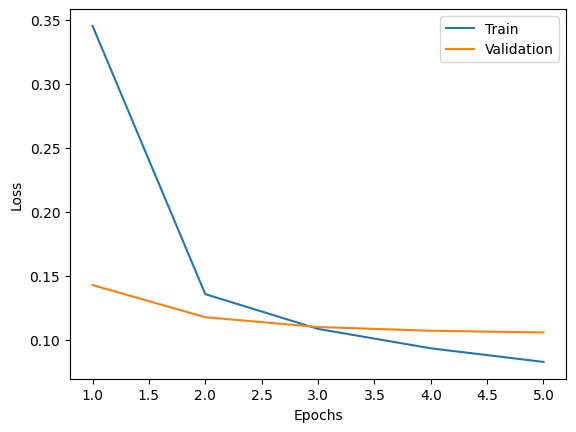

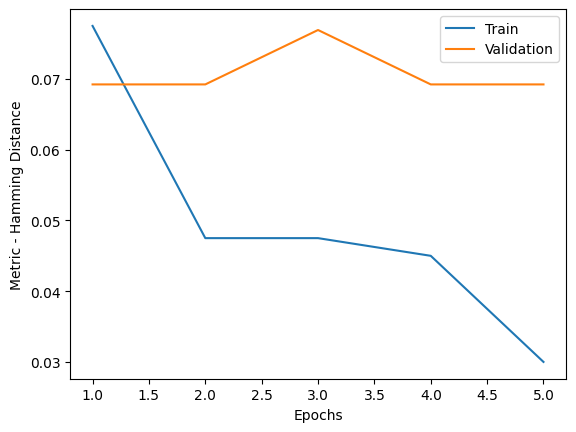

In [37]:
plot_history(train_losses, train_ham, valid_losses, valid_ham)

**Model Checkpointing**

In [38]:
from sklearn.metrics import confusion_matrix
from datetime import datetime
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/data/models/nlp_spring_2024/stack_exchange/2024-03-03_22-31-27_twolayer.pt')

In [39]:
# Save the model's state dictionary to the specified file path
torch.save(model_stack_1.state_dict(), path)

**Evaluate model on validation dataset**


In [40]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    #running_correct = 0
    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _, outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            predicted = (outputs.data>0.5).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))


    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, y, accuracy

In [41]:
# Get the prediction and accuracy
predictions_valid, labels_valid, acc_valid = get_acc_pred(valid_loader, model_stack_1, device)

In [42]:
# Get the prediction and accuracy for training and test data
predictions_train, labels_train, acc_train = get_acc_pred(train_loader, model_stack_1, device)

In [43]:
print('Valid accuracy', acc_valid * 100)

Valid accuracy tensor(96.2056, device='cuda:0')


In [44]:
print('Train accuracy', acc_train * 100)

Train accuracy tensor(98.2661, device='cuda:0')


In [45]:
from sklearn.metrics import multilabel_confusion_matrix

In [46]:
cm = multilabel_confusion_matrix(y_true = labels_valid.cpu().numpy(), y_pred = predictions_valid.cpu().numpy())
for i, matrix in enumerate(cm):
    print(f'Confusion matrix for class {i}:')
    print(matrix)

Confusion matrix for class 0:
[[7202  169]
 [ 461 1653]]
Confusion matrix for class 1:
[[7792   74]
 [ 159 1460]]
Confusion matrix for class 2:
[[8262   60]
 [ 407  756]]
Confusion matrix for class 3:
[[3665  360]
 [ 439 5021]]
Confusion matrix for class 4:
[[7963   40]
 [ 124 1358]]
Confusion matrix for class 5:
[[4238  219]
 [ 307 4721]]
Confusion matrix for class 6:
[[9316    4]
 [ 146   19]]
Confusion matrix for class 7:
[[9357    3]
 [  65   60]]
Confusion matrix for class 8:
[[9424    0]
 [  56    5]]
Confusion matrix for class 9:
[[6845  169]
 [ 337 2134]]


# <Font color = 'indianred'>**7. Model Testing or Expected Performance**

In [47]:
trained_model_stack_1 = SimpleMLP(input_dim = num_inputs,
                       hidden_dim1=Hidden_dim1,
                       hidden_dim2=Hidden_dim2,
                       drop_prob1=0.5,
                       drop_prob2=0.5,
                       output_dim=Num_Outputs)

checkpoint = torch.load(path)
trained_model_stack_1.load_state_dict(checkpoint)

<All keys matched successfully>

**Evaluate Model on Test Set**

In [48]:
predictions_test, labels_test, acc_test = get_acc_pred(test_loader, trained_model_stack_1, device)

In [49]:
print('Test accuracy', acc_test * 100)

Test accuracy tensor(96.0521, device='cuda:0')


In [50]:
# test confusion matrix
cm = multilabel_confusion_matrix(y_true = labels_test.cpu().numpy(), y_pred = predictions_test.cpu().numpy())
for i, matrix in enumerate(cm):
    print(f'Confusion matrix for class {i}:')
    print(matrix)

Confusion matrix for class 0:
[[7173  190]
 [ 494 1629]]
Confusion matrix for class 1:
[[7735   65]
 [ 205 1481]]
Confusion matrix for class 2:
[[8269   65]
 [ 427  725]]
Confusion matrix for class 3:
[[3717  352]
 [ 428 4989]]
Confusion matrix for class 4:
[[7919   39]
 [ 147 1381]]
Confusion matrix for class 5:
[[4328  224]
 [ 317 4617]]
Confusion matrix for class 6:
[[9308    9]
 [ 153   16]]
Confusion matrix for class 7:
[[9353    3]
 [  56   74]]
Confusion matrix for class 8:
[[9414    0]
 [  64    8]]
Confusion matrix for class 9:
[[6815  169]
 [ 338 2164]]
